### Include Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, validation_curve,\
ShuffleSplit, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, \
HashingVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from pandas_ml import ConfusionMatrix
import matplotlib.pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier
import itertools

### Import data

In [2]:
data = pd.read_csv('data/dataset_one/data_one.csv')
data.shape

(4005, 4)

In [3]:
print('Columns: ', data.columns)

Columns:  Index(['Headline', 'Body', 'Label', 'main_url'], dtype='object')


In [4]:
data.head(5)

,Headline,Body,Label,main_url
0,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1,www.bbc.com
1,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1,www.reuters.com
2,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1,www.nytimes.com
3,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1,www.reuters.com
4,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1,www.cnn.com


In [5]:
label_count = data['Label'].value_counts()
print('Label Count:\n\tFake: {}\n\tReal: {}'.format(label_count[0], label_count[1]))

Label Count:
	Fake: 2135
	Real: 1870


In [6]:
sources = data['main_url'].value_counts()
print('Total count of sources: ',len(sources))

Total count of sources:  19


### Text Preprocessing

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
# from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Remove empty (NaN) values with na in dataset
data = data.replace(np.nan, '<UNK>', regex=True)

#### Concatenate feature inputs

In [9]:
# Concatenating all text input features into one seperate column to process BOW and TF-IDF vectors
data['combined_input'] = data['main_url'].map(str) + ' '+data['Headline'].map(str)+' ' +data['Body'].map(str)

In [10]:
# Split data into train and test datasets
# 20% data will be used for testing and the rest will be used for training and validataion
# We will be using k-flod cross validation, therefore we do not need to split train data further into two parts as our k-flod CV
# will do that for us
seed = 99
np.random.seed(seed)
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = seed)

In [11]:
train_data.shape, test_data.shape

((3204, 5), (801, 5))

#### Train features and targets

In [12]:
# Split training data into input feauters and target
X_train, y_train = train_data.iloc[:,4].values, train_data.iloc[:,2].values

In [13]:
X_train.shape

(3204,)

In [14]:
y_train.shape

(3204,)

#### Test features and targets

In [15]:
# Split test data into input feauters and target
X_test, y_test = test_data.iloc[:,4].values, test_data.iloc[:,2].values

In [16]:
X_test.shape

(801,)

In [17]:
y_test.shape

(801,)

#### Clean text data

In [18]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [19]:
"""
REMOVE_STOPWORDS truncates stopwrds from the string and returns modified string
    INPUT:
        >> string
    OUTPUT:
        >> Modified string without stopwords
"""
def remove_stopwords(text):
    text = [word for word in text.split() if word not in STOPWORDS]
    text = ' '.join(text)
    return text

In [20]:
def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
     # convert all characters in a string to lowercase
    text = text.lower()
    
    #replace Symbols with a space in string
    text = re.sub(REPLACE_BY_SPACE_RE, " ",text)
    
    # delete unwanted synbols from string
    text = re.sub(BAD_SYMBOLS_RE,"", text)
    
    # delete stopwords from text
    text = remove_stopwords(text)
    
    return text

In [21]:
X_train = [text_prepare(x) for x in X_train]

In [22]:
X_test = [text_prepare(x) for x in X_test]

In [23]:
X_train[0]

'beforeitsnewscom would feel blackhawks lineup would feel blackhawks lineup news chicago blackhawks open 201718 nhl season tonight hosting twotime defending stanley cup champion pittsburgh penguins disappointing exit 2017 stanley cup playoffs hope blackhawks regain form make another run season roster set well better idea starting lineup might look like penguins prediction forwards saad toews panik hartman schmaltz kane sharp anisimov debrincat hayden kero wingels defensemen keith murphy forsling seabrook kempny rutta goalies crawford forsberg scratched bouma oesterle franson saad toews reunited think well see uptick production first line important thing missing hossa theyll make panik like call hossa lite better kane hartman flanks left side especially schmaltz centering hartman play boards get puck back kane schmaltz deep zone debrincat could benefit playing veterans like sharp anisimov get bearings could see debrincat spending time kane first power play unit throughout season defense

In [24]:
# Word Frequency calculator
def word_frequency(data):
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    words = {}
    for line in data:
        tokens = tokenizer.tokenize(line)
        for token in tokens:
            if token in words:
                count = words[token] + 1
                words[token] = count
            else:
                words[token] =  1
                
    return words

In [25]:
# Dictionary of all words from train corpus with their counts.
words_counts = word_frequency(X_train)

In [26]:
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:10]
most_common_words

[('said', 6533),
 ('us', 3457),
 ('new', 3385),
 ('one', 3312),
 ('would', 3228),
 ('also', 2673),
 ('first', 2411),
 ('two', 2403),
 ('like', 2234),
 ('people', 2144)]

### BOW Approach

In [27]:
DICT_SIZE = 5000
WORDS_TO_INDEX = {b[0]:a for a,b in enumerate(sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:5000])}
INDEX_TO_WORDS = {b:a for a,b in WORDS_TO_INDEX.items()}
ALL_WORDS = WORDS_TO_INDEX.keys()

In [28]:
def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
      # create a zero vector equaling the size of words list
    result_vector = np.zeros(dict_size)
    for word in set(text.split()):
        if word in words_to_index:
            result_vector[words_to_index[word]] = 1
            
    return result_vector

In [29]:
from scipy import sparse as sp_sparse

In [30]:
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (3204, 5000)
X_test shape  (801, 5000)


In [31]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = len(np.nonzero(row)[0])

In [32]:
non_zero_elements_count

333

In [33]:
X_train_mybag.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

# TF-IDF APPROACH

In [34]:
def tfidf_features(X_train,  X_test):
    """
        X_train,  X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tf_idf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.8,ngram_range=(1,3), token_pattern='(\S+)')
    features = tf_idf_vectorizer.fit(X_train)
    
    X_train = features.transform(X_train)
    X_test = features.transform(X_test)
    
    return X_train, X_test, tf_idf_vectorizer.vocabulary_
    

In [35]:
%%time
X_train_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train,  X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

Wall time: 11.3 s


In [36]:
len(tfidf_reversed_vocab), X_train_tfidf.shape

(31551, (3204, 31551))

In [37]:
y_train.shape

(3204,)

### Naive Bayes Classifieer

In [38]:
"""
CONFUSION MATRIX
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [39]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### BOW APPROACH

In [40]:
# Navie Bayes classifier on BOW data
classifier_bow = MultinomialNB()

In [41]:
classifier_bow.fit(X_train_mybag, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
prediction_bow = classifier_bow.predict(X_test_mybag)

In [43]:
cm_bow = metrics.confusion_matrix(y_test, prediction_bow, labels=[0,1])

In [45]:
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

<module 'matplotlib.pyplot' from 'C:\\Users\\abhi\\Anaconda3\\envs\\tf_gpu_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

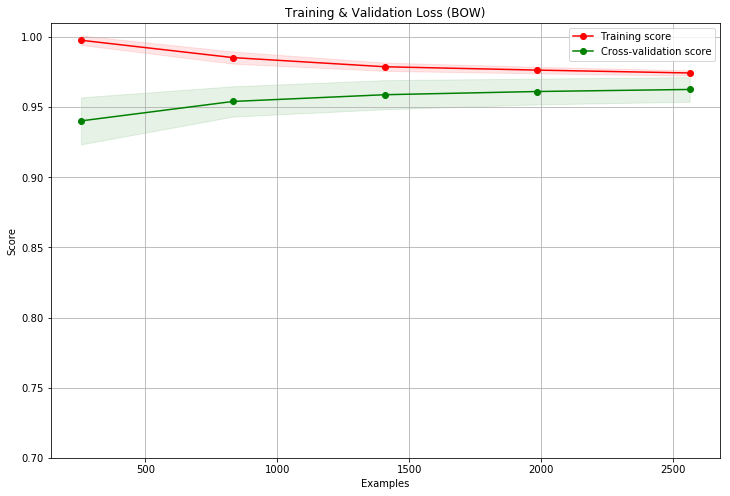

In [46]:
plot_learning_curve(classifier_bow, 
                    "Training & Validation Loss (BOW)", 
                    X_train_mybag, 
                    y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [47]:
score_bow = metrics.accuracy_score(y_test, prediction_bow)
print('Accuracy Score: ', score_bow)

Accuracy Score:  0.9575530586766542


Confusion matrix, without normalization


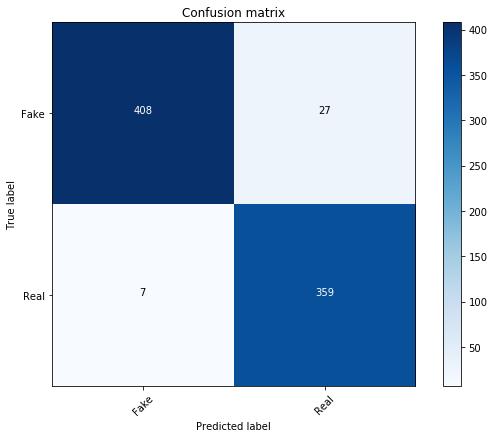

In [48]:
cm_bow = metrics.confusion_matrix(y_test, prediction_bow, labels=[0,1])
plot_confusion_matrix(cm_bow, classes=['Fake','Real'])

### TF-IDF APPROACH

In [49]:
# Navie Bayes classifier on TF-IDF data
classifier_tf_idf = MultinomialNB()

In [50]:
classifier_tf_idf.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [51]:
prediction_tf_idf = classifier_tf_idf.predict(X_test_tfidf)

<module 'matplotlib.pyplot' from 'C:\\Users\\abhi\\Anaconda3\\envs\\tf_gpu_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

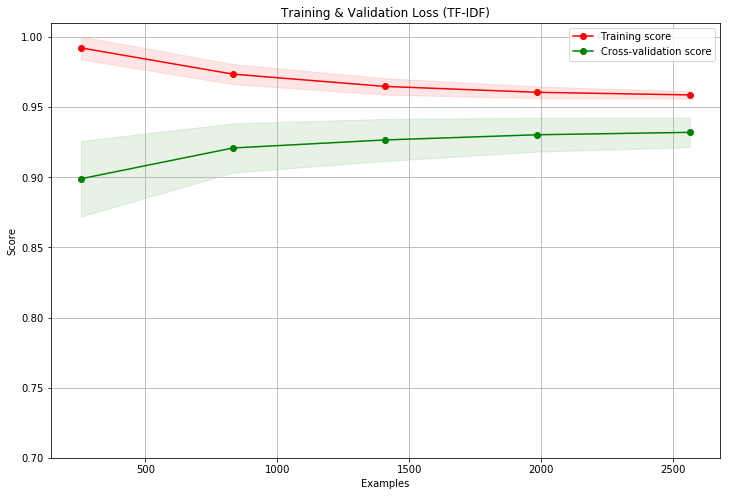

In [52]:
plot_learning_curve(classifier_tf_idf, 
                    "Training & Validation Loss (TF-IDF)", 
                    X_train_tfidf, 
                    y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)

In [53]:
score_tf_idf = metrics.accuracy_score(y_test, prediction_tf_idf)
print('Accuracy Score: ', score_tf_idf)

Accuracy Score:  0.9375780274656679


In [54]:
cm_tf_idf = metrics.confusion_matrix(y_test, prediction_tf_idf, labels=[0,1])

Confusion matrix, without normalization


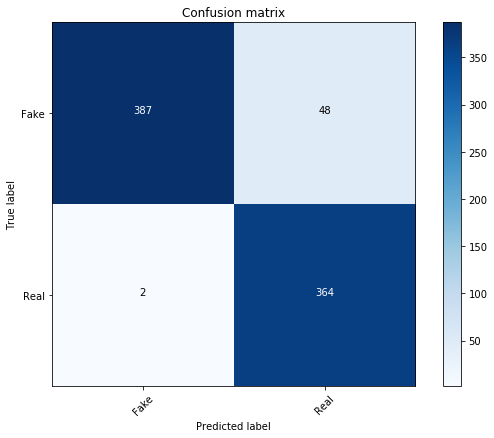

In [55]:
plot_confusion_matrix(cm_tf_idf, classes=['Fake', 'Real'])